### Module import

In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load image

In [2]:

img_path = '00000634_000.png'
pil_img = PIL.Image.open(img_path)

# Convert the image to RGB format and resize it
pil_img = pil_img.convert("RGB")
pil_img = pil_img.resize((224, 224))

In [3]:
pil_img.size

(224, 224)

### preprocess image

In [4]:


torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
torch_img = torch.unsqueeze(torch_img, 0)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)

print(normed_torch_img.shape)


torch.Size([1, 3, 224, 224])


In [5]:
print(normed_torch_img.shape)

torch.Size([1, 3, 224, 224])


### Load torchvision models and make configs

In [6]:

densenet = models.densenet161(pretrained=True)


d:\envs\mgit2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\envs\mgit2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
CKPT_PATH = 'DenseNet121_aug4_pretrain_WeightBelow1_1_0.829766922537.pkl'

In [8]:
densenet.load_state_dict(torch.load("your.pth.tar"),strict=False)

_IncompatibleKeys(missing_keys=['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2.norm1.running_var', 'features.denseblock1.denselayer2.conv1.weight', 'features.denseblock1.denselayer2.norm2.weight', 'features.denseblock1.d

In [9]:
# if os.path.isfile(CKPT_PATH):
#         print("=> loading checkpoint")
#         checkpoint = torch.load(CKPT_PATH)
#         densenet.load_state_dict(checkpoint['model_state_dict'], strict=False )
#         print("=> loaded checkpoint")
# else:
#         print("=> no checkpoint found")

In [10]:
configs = [

    dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),

]

In [11]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [16]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    # Remove the batch dimension for visualization tensors
    heatmap = heatmap.squeeze(0)
    result = result.squeeze(0)
    heatmap_pp = heatmap_pp.squeeze(0)
    result_pp = result_pp.squeeze(0)

    # Remove the batch dimension for input image tensor
    torch_img_cpu = torch_img.cpu().squeeze(0)

    images.extend([torch_img_cpu, heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images[3:], nrow=5)


### Show results 

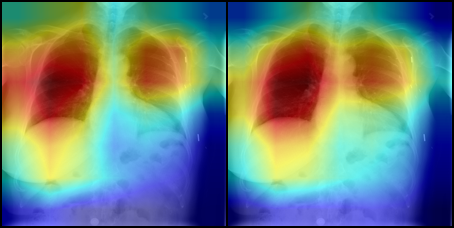

In [17]:
transforms.ToPILImage()(grid_image)

In [ ]:
pil_image = transforms.ToPILImage()(grid_image)

# Save the PIL image
pil_image.save("grid_image.png")